# Explainable AI

## What is the problem?

![](images/programing-ml.png)
![](images/iml-ml.png)

## Why do we need Explainable AI?

![](images/explain.png)

## Agnostic-model

![](images/black-box.png)
![](images/agnostic-black-box.png)

## Permutation Importance

It is a method to evaluate how important a single feature is in a trained model and is computed as follows:

1. Train a model on a dataset.
2. Shuffle the values in a single column (e.g., the values of a single features).
3. Apply the  model both to the original data and to shuffled data.
4. Compute the feature importance as the loss of performance when the model is applied to the suffled data.

![](images/perm1.png)
![](images/perm2.png)


### Additional notes

* How to do permutation? 
    * half dataset swap
    * generate n*n-1 samples 

* Use training set or test set?

### Examples

We will use the [eli5](https://eli5.readthedocs.io/en/latest/) library that provide implementation for the [PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#module-eli5.sklearn.permutation_importance):

#### Man of the Match (Classification)

In [1]:
#STEP 1

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

fifa_data = pd.read_csv('data/FIFA 2018 Statistics.csv')
fifa_y = (fifa_data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
fifa_feature_names = [i for i in fifa_data.columns if fifa_data[i].dtype in [np.int64]]
fifa_X = fifa_data[fifa_feature_names]
fifa_train_X, fifa_val_X, fifa_train_y, fifa_val_y = train_test_split(fifa_X, fifa_y, random_state=1)
fifa_forest_model = RandomForestClassifier(random_state=0,n_estimators=100).fit(fifa_train_X, fifa_train_y)

In [2]:
#STEP 2-4

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(fifa_forest_model, random_state=1).fit(fifa_val_X, fifa_val_y)
print(perm.feature_importances_)
print(fifa_val_X.columns)
eli5.show_weights(perm, feature_names = fifa_val_X.columns.tolist())

[ 0.175    0.00625 -0.01875  0.       0.01875  0.0125  -0.00625 -0.00625
  0.01875  0.00625  0.0125  -0.05     0.05     0.01875  0.04375  0.
  0.      -0.00625]
Index(['Goal Scored', 'Ball Possession %', 'Attempts', 'On-Target',
       'Off-Target', 'Blocked', 'Corners', 'Offsides', 'Free Kicks', 'Saves',
       'Pass Accuracy %', 'Passes', 'Distance Covered (Kms)',
       'Fouls Committed', 'Yellow Card', 'Yellow & Red', 'Red',
       'Goals in PSO'],
      dtype='object')


Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


### Bike Sharing (Regression)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, make_scorer

bike_data = pd.read_csv('data/day.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


R^2 = 0.6204962981655062
MAE = 1008.6907103825134


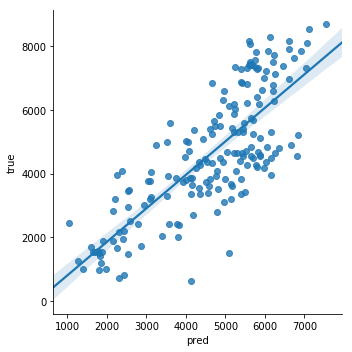

In [4]:
bike_y = bike_data['cnt']
bike_y.head()
bike_X = bike_data.drop(['instant','dteday','yr','casual','registered','cnt'], axis=1)
bike_features = bike_X.columns
bike_train_X, bike_val_X, bike_train_y, bike_val_y = train_test_split(bike_X, bike_y, random_state=2)
bike_forest_model = RandomForestRegressor(random_state=0, n_estimators=100).fit(bike_train_X, bike_train_y)
bike_pred_y = bike_forest_model.predict(bike_val_X)
bike_pred = pd.DataFrame({'pred':bike_pred_y, 'true':bike_val_y}) 
print('R^2 = {}'.format(bike_forest_model.score(bike_val_X,bike_val_y)))
sns.lmplot('pred', 'true', data=bike_pred)
print ('MAE = {}'.format(mean_absolute_error (bike_val_y, bike_pred_y)))

In [5]:
import eli5
from eli5.sklearn import PermutationImportance

bike_forest_perm = PermutationImportance(bike_forest_model, random_state=1).fit(bike_val_X, bike_val_y)
print(bike_val_X.columns)
print(bike_forest_perm.feature_importances_)

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[0.06368706 0.02877708 0.00180608 0.0009005  0.00216604 0.00851111
 0.45024241 0.11873014 0.20040964 0.04374371]


In [6]:
eli5.show_weights(bike_forest_perm, feature_names = bike_val_X.columns.tolist())

Weight,Feature
0.4502 ± 0.0636,temp
0.2004 ± 0.0843,hum
0.1187 ± 0.0191,atemp
0.0637 ± 0.0346,season
0.0437 ± 0.0505,windspeed
0.0288 ± 0.0189,mnth
0.0085 ± 0.0073,weathersit
0.0022 ± 0.0045,workingday
0.0018 ± 0.0004,holiday
0.0009 ± 0.0093,weekday


In [7]:
bike_forest_MAE_perm = PermutationImportance(bike_forest_model, scoring=make_scorer(mean_absolute_error, greater_is_better=False), random_state=1).fit(bike_val_X, bike_val_y)
eli5.show_weights(bike_forest_MAE_perm, feature_names = bike_val_X.columns.tolist())



Weight,Feature
457.6072 ± 46.9390,temp
199.8188 ± 109.9320,hum
186.0646 ± 27.3122,atemp
79.4779 ± 53.2381,season
54.7392 ± 57.1319,windspeed
40.3606 ± 25.9528,mnth
10.5403 ± 15.7857,weathersit
5.0179 ± 12.2323,weekday
2.2707 ± 6.4406,workingday
1.1791 ± 1.1992,holiday


## Partial Dependence Plot

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

It works as follows:

1. Train a model on data.
2. Run the model on each sample by changing only the value of target feature(s) (from a set of values in the feature range).
3. Compute and plot the model output for each value of the feature.

### Example: Man of the match (classification)

In [8]:
from sklearn.tree import DecisionTreeClassifier

fifa_simpletree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(fifa_train_X, fifa_train_y)

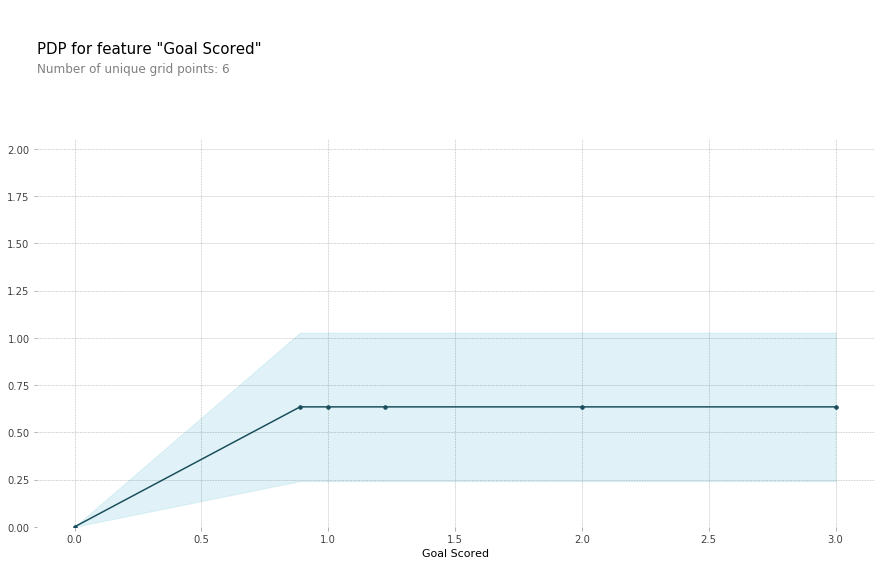

In [9]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=fifa_simpletree_model, dataset=fifa_val_X, model_features=fifa_feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

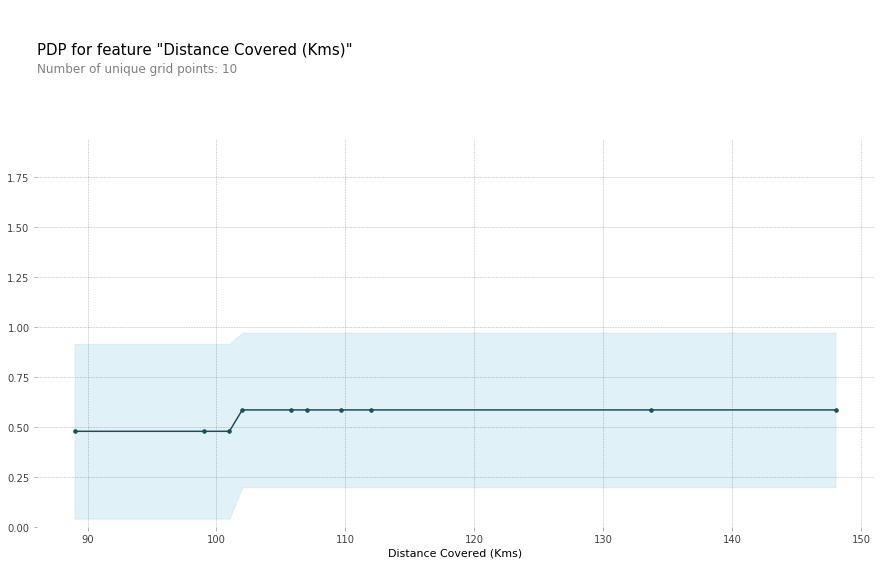

In [10]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=fifa_simpletree_model, dataset=fifa_val_X, model_features=fifa_feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot, center=False)
plt.show()

Let's check the model to understand the plot above:

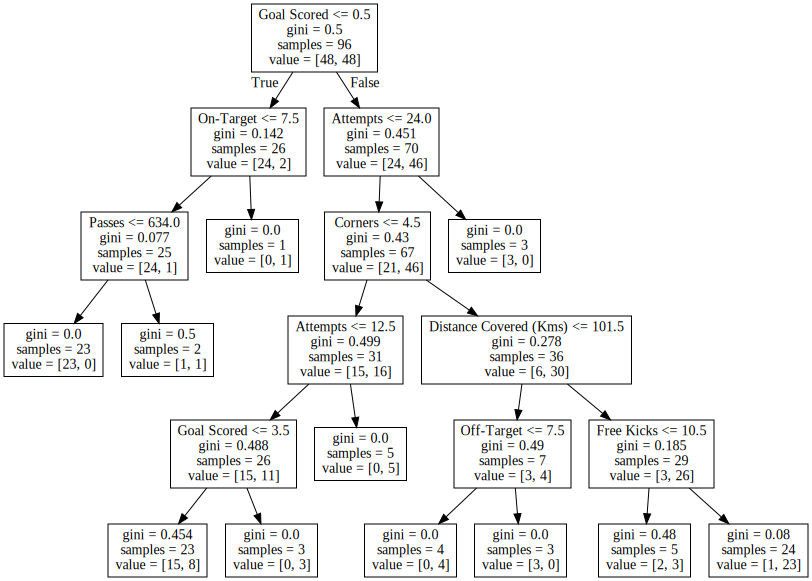

In [11]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(fifa_simpletree_model, out_file=None, feature_names=fifa_feature_names)
graphviz.Source(tree_graph)

What happens if we use a more complex models:

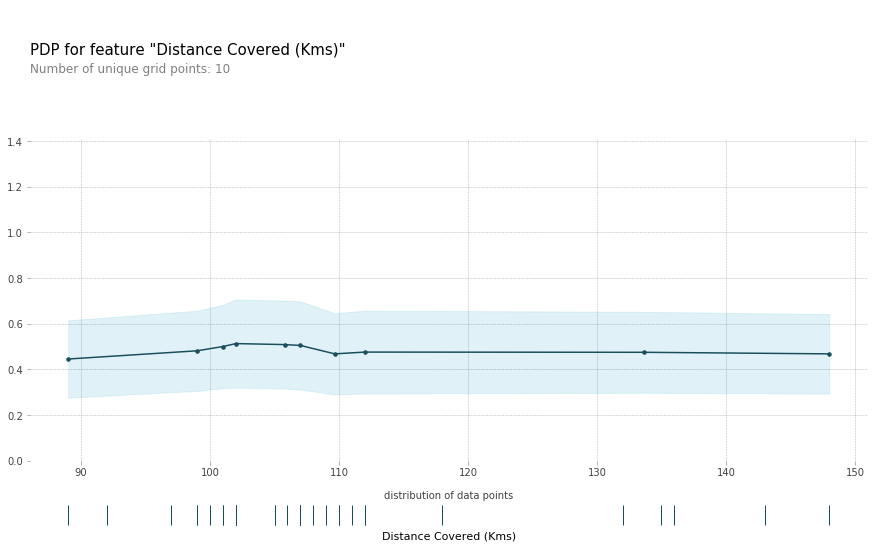

In [12]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0, n_estimators=100).fit(fifa_train_X, fifa_train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=fifa_val_X, model_features=fifa_feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot, plot_pts_dist=True, center=False)
plt.show()

### Example: Bike Rental Regression Problem

The examples use the [PDPbox library](https://github.com/SauceCat/PDPbox)

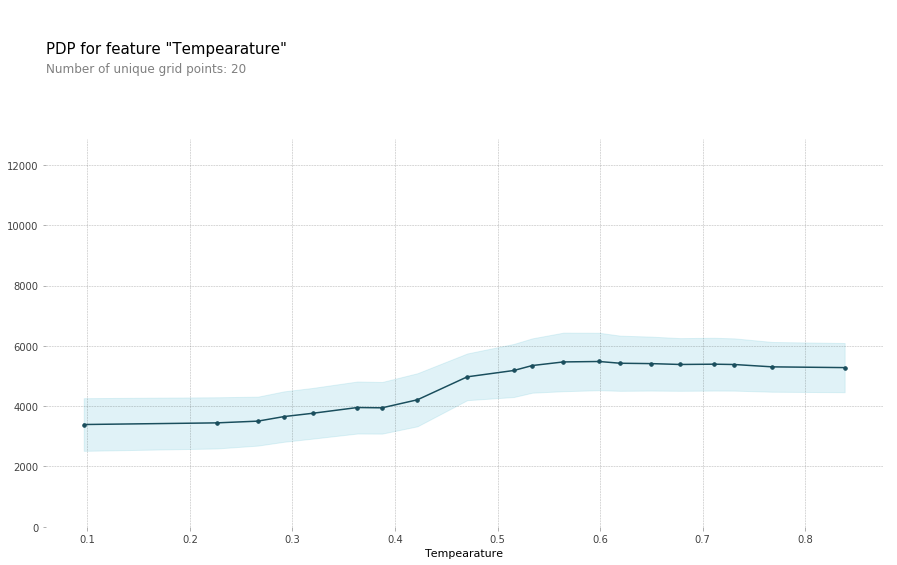

In [13]:
from matplotlib import pyplot as plt
from pdpbox import pdp


# Create the data that we will plot
pdp_temp = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='temp', num_grid_points=20)

# plot it
pdp.pdp_plot(pdp_temp, 'Tempearature', center=False)
plt.show()

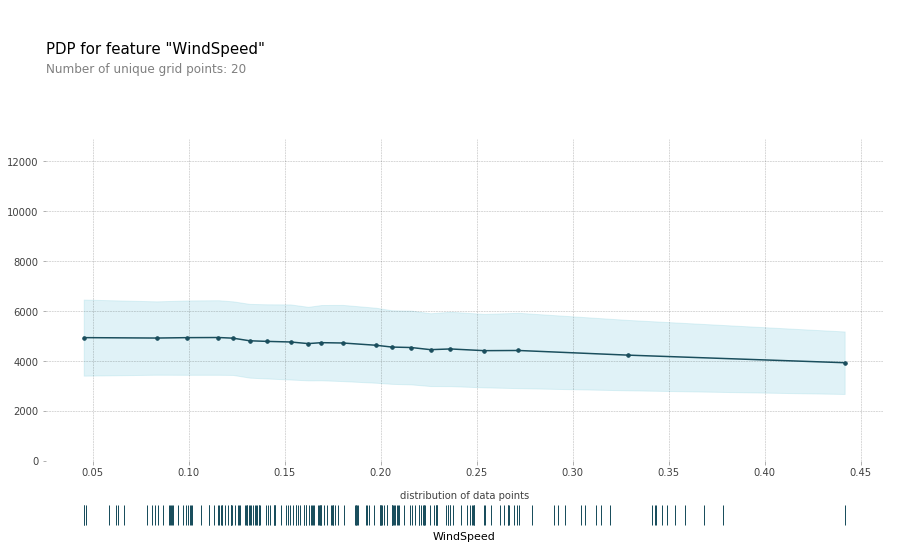

In [ ]:
# Create the data that we will plot
pdp_wind = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='windspeed', num_grid_points=20)

# plot it
pdp.pdp_plot(pdp_wind, 'WindSpeed', center=False, plot_pts_dist=True)
plt.show()

In [ ]:
# Create the data that we will plot
pdp_hum = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='hum', num_grid_points=10)

# plot it
pdp.pdp_plot(pdp_hum, 'Humidity', center=False, plot_pts_dist=True, x_quantile=True)
plt.show()

In [ ]:
# Create the data that we will plot
pdp_season = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='season', num_grid_points=20)

plt.bar(['Spring','Summer','Fall','Winter'],pdp_season.pdp)


Can we look at two features at the same time:

In [ ]:
inter1 = pdp.pdp_interact(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, features=['temp','hum'])
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Temperature', 'Humidity'], 
                      plot_type='contour', x_quantile=False)
plt.show()

In [ ]:
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Temperature', 'Humidity'], 
                      plot_type='grid', plot_pdp=True, x_quantile=True)
plt.show()

### Limitations and remarks

* Maximum number of features analyzed is 2 
* PD plots should not omit distribution, otherwise they can be misleading
* Strong underlying assumption: features are not correlated
* Show average effect on the whole dataset --> ICE

## Individual Conditional Expectation (ICE)

* These plots are very similar to PDP plot, but they show one line per instance in the dataset, showing how the prediction change.

* They solve the "averaging" problem of PDP.

* To simplify comparison between lines, centered ICE can be plot by showing the prediction change with respect to the baseline (usually the model output for the leftmost value of the feature).

* ICE can show only one feature at once.

* Same underlying assumption of PDP: if features are correlated some area of the space are meaningless.


### Examples

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp


# Create the data that we will plot
pdp_temp = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='temp', num_grid_points=20)
pdp_hum = pdp.pdp_isolate(model=bike_forest_model, dataset=bike_val_X, model_features=bike_features, feature='hum', num_grid_points=10)


# plot it
pdp.pdp_plot(pdp_temp, 'Tempearature', center=False, plot_lines=True, plot_pts_dist=True)
pdp.pdp_plot(pdp_hum, 'Humidity', center=False, plot_lines=True, plot_pts_dist=True)
plt.show()



In [ ]:
#Now Centered ICE
pdp.pdp_plot(pdp_temp, 'Tempearature', center=True, plot_lines=True, plot_pts_dist=True)
pdp.pdp_plot(pdp_hum, 'Humidity', center=True, plot_lines=True, plot_pts_dist=True)
plt.show()


## SHapley Additive exPlanations (SHAP)


The underlying idea of SHAP values is being able to break down a model prediction by showing the contribution of each feature.

In particular, the goal here is compuing for each feature j, the contribution ϕ<sub>j</sub> such that 

∑ϕ<sub>i</sub> = f(x) - E<sub>X</sub>(f(x))


Let's consider first a linear model:


f(x) = β<sub>0</sub> + β<sub>1</sub>x<sub>1</sub> + ... + β<sub>n</sub>x<sub>n</sub>

We can easily compute the contribution of each feature as:

ϕ<sub>i</sub> = β<sub>i</sub>x<sub>i</sub> - β<sub>i</sub>E(X)


Can we do the same for any type of model? It would be great to have this as a model-agnostic tool. Since we usually do not have similar weights in other model types, we need a different solution.

Help comes from unexpected places: cooperative game theory. The Shapley value is a solution for computing feature contributions for single predictions for any machine learning model.

The Shapley value, coined by Shapley in 1953, is a method for assigning payouts to players depending on their contribution to the total payout. Players cooperate in a coalition and receive a certain profit from this cooperation.

In our case:

* prediction <-- payout
* players <--- feature values

Since in a general model we cannot assume that feature contributions are linearly separated, the Shapley value is computed as the marginal contribution of each feature as follows: 


ϕ<sub>i</sub> = (1/N) ∑<sub>j</sub> VAL(S<sub>j</sub> ∪ x<sub>i</sub>) -  VAL(S<sub>j</sub>)

where S are all the possible subset of the features values in x except for x<sub>i</sub>, VAL(S<sub>j</sub> ∪ x<sub>i</sub>) is the expected value of the prediction when S<sub>j</sub> features values are fixed as well x<sub>i</sub>, while VAL(S<sub>j</sub>) is the expected value of prediction when only S<sub>j</sub> features values are fixed.

This is computed in practice with the following approximation:

FOR m = 1, ..., M

* Draw random instance z from the data matrix X
* Choose a random permutation O of the feature values
* Create instance x<sub>+j</sub> by replacing all the features that follow feature i in O with values taken from z
* Create instance x<sub>-j</sub> by replacing all the features feature i and all the feature that follows it in O with values taken from z
* Update ϕ<sub>i</sub> as ϕ<sub>i</sub> = ϕ<sub>i</sub> + 1/M ( f(x<sub>+j</sub>) - f(x<sub>-j</sub>)) 


### Example: Man of the Match (Classification)

We will use the [Shap library](https://github.com/slundberg/shap)

In [ ]:
import shap  # package used to calculate Shap values

explainer = shap.KernelExplainer(rf_model.predict_proba, fifa_train_X)

In [ ]:
#Let see an example on prediction

pred_to_explain=5

shap_val=explainer.shap_values(fifa_val_X.iloc[pred_to_explain,:])
expl = pd.DataFrame({'feat_name': fifa_train_X.columns.values, 'feat_val': fifa_val_X.iloc[pred_to_explain,:], 'shap_val':  shap_val[1]})
expl



In [ ]:
# let's plot the Shap values
sns.set(context='talk', style="whitegrid", rc={'figure.figsize':[12,12]})
sns.barplot(x='shap_val', y='feat_name', data=expl)
plt.show()

In [ ]:
# A nice representation is provided by force plots

# load JS visualization code to notebook
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_val[1], fifa_val_X.iloc[pred_to_explain,:] )

## Example: Bike Rental (Regression)

In [ ]:
explainer = shap.KernelExplainer(bike_forest_model.predict, shap.kmeans(bike_train_X,2))


shap_val=explainer.shap_values(bike_val_X.iloc[pred_to_explain,:])
expl = pd.DataFrame({'feat_name': bike_train_X.columns.values, 'feat_val': bike_val_X.iloc[pred_to_explain,:], 'shap_val':  shap_val})
expl

In [ ]:
# load JS visualization code to notebook
shap.initjs()

shap.force_plot(explainer.expected_value, shap_val, bike_val_X.iloc[pred_to_explain,:] )

In [ ]:
# We can also explain all the predictions

all_shap_val = explainer.shap_values(bike_val_X)

In [ ]:
# Now we can show force plot for the whole dataset
shap.force_plot(explainer.expected_value, all_shap_val, bike_val_X)

In [ ]:
# We can also have a sumary plot of the shap values
shap.summary_plot(all_shap_val, bike_val_X)
shap.summary_plot(all_shap_val, bike_val_X, plot_type="bar")

In [ ]:
# We can also get a dependency plot

shap.dependence_plot('temp', all_shap_val, bike_val_X, interaction_index=None)
shap.dependence_plot('hum', all_shap_val, bike_val_X, interaction_index=None)
shap.dependence_plot('temp', all_shap_val, bike_val_X, interaction_index='hum')

### Final remarks on Shapley Values
Pros
* solid theoretical framework
* nice properties (additivity, contributions fairly distributed)
* allow constrastive explanations using a subset of data to compute the values

Cons
* computationally expensive
* no simple (sparse) explanations are possible

## Local Surrogate (LIME)

The recipe for training local surrogate models:

* Select your instance of interest for which you want to have an explanation of its black box prediction.
* Perturb your dataset and get the black box predictions for these new points.
* Weight the new samples according to their proximity to the instance of interest.
* Train a weighted, interpretable model on the dataset with the variations.
* Explain the prediction by interpreting the local model.

![](images/lime.png)


### Example: Man of the Match (Classification)

We will use the [Lime library](https://github.com/marcotcr/lime) and in particular [lime.tabular](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular)

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(fifa_train_X.values, feature_names=fifa_feature_names, 
                                                   class_names=['No', 'Yes'], discretize_continuous=True, 
                                                   verbose=True)

In [ ]:
i = 1
exp = explainer.explain_instance(fifa_val_X.iloc[i].values, rf_model.predict_proba, num_features=4)
exp.show_in_notebook(show_table=True, show_all=True)

In [ ]:
exp.as_list()

### Example: Bike Rental (Regression)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(bike_train_X.values, feature_names=bike_features, 
                                                   class_names=['count'], mode='regression', 
                                                   discretize_continuous=True, verbose=True)

In [ ]:
i = 1
exp = explainer.explain_instance(bike_val_X.iloc[i].values, bike_forest_model.predict, num_features=5)
exp.show_in_notebook(show_table=True, show_all=True)

In [ ]:
exp.as_list()

## References

* [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
* [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)